In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt




In [114]:

embeddings_df = pd.read_csv("out/embeddings_processed.csv")
structured_df = pd.read_csv("out/data.csv")

embeddings_df = embeddings_df['embedding'].str.split(',', expand=True)

# Optional: convert all columns to float
embeddings_df = embeddings_df.astype(float)

# Optional: rename columns like 'emb_0', 'emb_1', ...
embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]

# data = pd.concat([embeddings_df, structured_df], axis=1)
data = pd.concat([embeddings_df, structured_df["OS"]], axis=1)

# Step 3: Initial exploration
print("Initial data shape:", data.shape)
print(data.head())
print(data.info())
print(data['OS'].value_counts())


Initial data shape: (658, 769)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.372847  1.175885 -0.136382  0.584974 -0.075458  0.242736 -0.091984   
1 -0.356913  0.706686  0.037918  0.460797 -0.655461 -0.034329 -0.260771   
2 -0.650745  0.622192 -0.541576 -0.147439 -0.688726  0.005337  0.160113   
3 -0.243454  0.907251 -0.278341  0.578471 -0.371568  0.370125 -0.096557   
4 -0.501727  0.816661 -0.331489  0.102610 -0.754066  0.199273  0.021237   

      emb_7     emb_8     emb_9  ...   emb_759   emb_760   emb_761   emb_762  \
0  0.850612  1.272928 -0.353911  ...  0.614081  1.301343 -0.603757  1.090085   
1  0.986547  1.546444 -0.446621  ...  0.176466  1.770456 -0.477023  1.254743   
2  0.956877  0.844839 -0.026274  ...  0.446462  1.798108 -0.837940  0.912195   
3  0.984593  1.147140 -0.293077  ...  0.529422  1.466555 -0.401948  0.902150   
4  0.814512  1.281691 -0.193750  ...  0.411068  1.895289 -0.763574  1.106755   

    emb_763   emb_764   emb_765   emb

In [115]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)



In [116]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns


In [117]:
num_imputer = SimpleImputer(strategy='median')
for col in num_cols:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(float)
        data[col] = num_imputer.fit_transform(data[[col]])


In [118]:
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_cols]),
        columns=cat_cols,
        index=data.index
    )


In [119]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le


In [120]:
X = data.drop('OS', axis=1)
y = data['OS']  # make sure OS is categorical (0/1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Create and fit PCA
pca = PCA(n_components=19)  # reduce to 10 dimensions
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [121]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [122]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [123]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6060606060606061
Classification Report:
               precision    recall  f1-score   support

         0.0       0.36      0.08      0.13        49
         1.0       0.63      0.92      0.75        83

    accuracy                           0.61       132
   macro avg       0.50      0.50      0.44       132
weighted avg       0.53      0.61      0.52       132

Confusion Matrix:
 [[ 4 45]
 [ 7 76]]


In [124]:
y_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.5424145561839193


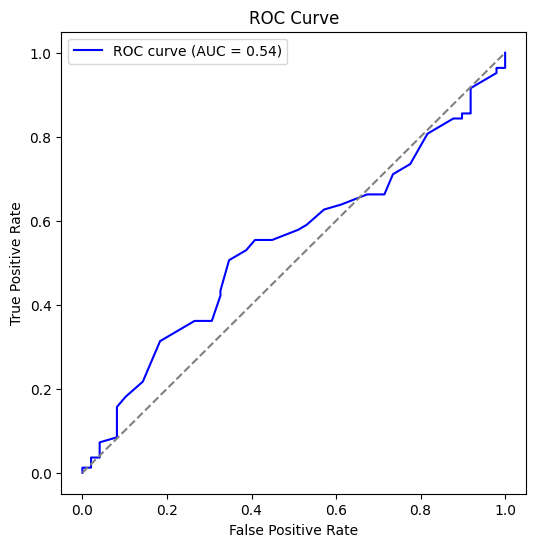

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
